In [1]:
import torch
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

from llm.data import load_dataset, text_to_tensor, tensor_to_text
from llm.training import TransformerLMTrainingLoop, TrainingLogs
from llm.transformer import CharGenerativeTransformer

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

In [4]:
(train_dataset, valid_dataset), ctoi, itoc = load_dataset(
    Path("dataset", "lotr.txt"), slice(0, 2_000_000), slice(2_000_000, None)
)

print(f"Train dataset length:      {len(train_dataset)} characters")
print(f"Validation dataset length: {len(valid_dataset)} characters")

Train dataset length:      2000000 characters
Validation dataset length: 579949 characters


In [5]:
sequence_length = 512

model = CharGenerativeTransformer(
    vocab_size=len(ctoi),
    seq_length=sequence_length,
    embedding_dim=64,
    latent_dim=256,
    n_heads=8,
    n_layers=4
)

print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

CharGenerativeTransformer(
  (token_embedding): Embedding(96, 64)
  (position_embedding): Embedding(512, 64)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_feature

/home/victor/miniconda3/envs/ml-pytorch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience=25)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [7]:
n_epochs = 1000
batch_size = 32
# batch_size = 16

training_loop = TransformerLMTrainingLoop(
    device, n_epochs, sequence_length, batch_size,
    train_dataset, valid_dataset,
    model, optimizer, scheduler
)

with TrainingLogs() as logs:
    training_loop.run(logs)

Training on device cuda
epoch     0/999: train loss = 2.819225, valid loss = 2.489055, learning rate = 0.001


KeyboardInterrupt: 

In [8]:
def display_training_review(train_losses, valid_losses=None, learning_rates=None):
    fig, ax = plt.subplots()

    ax.set_title("Cross entropy over the epochs")
    ax.plot(train_losses, label="train loss")
    if valid_losses is not None:
        ax.plot(valid_losses, label="valid loss")
        best_valid_epoch = np.argmin(valid_losses)
        best_valid = valid_losses[best_valid_epoch]
        ax.plot(best_valid_epoch, best_valid, 'or')
        ax.text(best_valid_epoch, best_valid, f"({best_valid_epoch}, {best_valid:.6f})", ha='center', va='top', color='red')
    ax.legend(loc='upper right')
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.grid()

    if learning_rates is not None:
        lr_ax = ax.twinx()
        lr_ax.plot(learning_rates, ':r', label='learning rate')
        lr_ax.set_xlabel("epoch")
        lr_ax.set_ylabel("learning rate")
        lr_ax.legend(loc='lower left')

    fig.tight_layout()
    plt.show()

Training time: 51 seconds


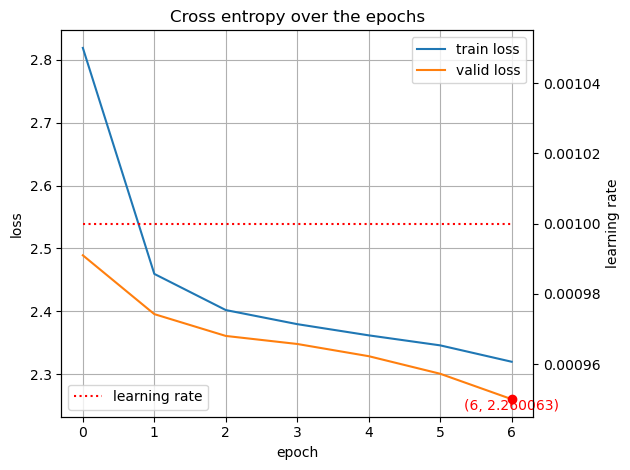

In [9]:
print(f"Training time: {logs.ellapsed_time:.0f} seconds")
display_training_review(logs.train_loss, logs.valid_loss, logs.lr)

In [10]:
def print_prediction_examples(model, test_contexts, n_predictions=80, repeat=4):
    model.eval()

    with torch.no_grad():
        print("Deterministic predictions:")
        for context in test_contexts:
            context_tokens = text_to_tensor(context, ctoi)
            predicted_tokens = model.predict_argmax(context_tokens, n_predictions)
            predicted_text = tensor_to_text(predicted_tokens, itoc)
            print(f"{repr(context)} -> {repr(predicted_text)}")

        print("\nProbabilistic predictions:")
        for context in test_contexts:
            for _ in range(repeat):
                predicted_tokens = model.predict_proba(context_tokens, n_predictions)
                predicted_text = tensor_to_text(predicted_tokens, itoc)
                print(f"{repr(context)} -> {repr(predicted_text)}")

In [11]:
test_contexts = (
    "The throne",
    "Aragorn son of",
    "He paused, ",
    "the ring of ",
    "suddenly",
    "you cannot ",
    "I am a servant of the Secret Fire",
)
model.to(cpu)
model.eval()
print_prediction_examples(model, test_contexts, 80)

Deterministic predictions:
'The throne' -> ' the the the the the the the the the the the the the the the the the the the the'
'Aragorn son of' -> ' the the the the the the the the the the the the the the the the the the the the'
'He paused, ' -> 'the the the the the the the the the the the the the the the the the the the the '
'the ring of ' -> 'the the the the the the the the the the the the the the the the the the the the '
'suddenly' -> ' the the the the the the the the the the the the the the the the the the the the'
'you cannot ' -> 'the the the the the the the the the the the the the the the the the the the the '
'I am a servant of the Secret Fire' -> ' the the the the the the the the the the the the the the the the the the the the'

Probabilistic predictions:
'The throne' -> 'sif e. Dod, sceameremp aiknt and so ano dond onght f o vichut hondeathalf ollom '
'The throne' -> ' ll delyeand ot. Iby dokse we heathene fl bemee re fanan ifathes s grathive-ve w'
'The throne' -> 'l lyend 